# Exploration of GDELT Dataset

## Executive Summary

<p style="text-align: justify">
This notebook explores certain events extracted from the GDELT Dataset. The size of the dataset is 542Gb worth of compressed open source index of the world's news media.  Records and meta information are grouped into three tables namely Events, Mentions and Global Knowledge Graph (GKG). The tables were stored in compressed CSV files separated by date and table type. The use of primitive Python data structures to summarize insights is inherently tricky especially since we are dealing with large quantities of data. Hence, this notebook leverage Dask to enable parallel and out-of-core computation. Using parallel computing, we achieved to collate general information capturing the potential theoretical impact specific types of event will have on the stability of a country.  We also included comparing sentiment scores as an indicator of an event's importance. Results show that for three months (May-July) last year, Northern Africa and Central Asia had events which are negatively impactful from a political stability perspective. 
</p>

## Introduction

<p style="text-align:justify">
The Global Database of Events, Language, and Tone, which known as GDELT, is a new CAMEO-coded dataset containing geo-located events with global coverage from 1979 to the present. Each record is consist of two actors and the action performed by Actor1 upon Actor2. Additionally as stated in the GDELT codebook, a wide array of variables break out the raw CAMEO actor codes into their respective fields to make it easier to interact with the data.  Action codes are broken out into their hierarchy with Goldstein ranking scores included.  Plus a unique array of georeferencing fields that offer estimated landmark-centroid-level geographic positioning of both actors and the location of the action. Lastly, a new “Mentions” table that records the network trajectory of the story of each event “in flight” through the global media system.
</p>

<p style="text-align:justify">
With large chunks of records from this dataset coming from a multitude of news sources stored in a set of compressed files, the average personal notebook computer would have much of a difficulty attaining speedup. An analysis would mean to take some time if we pursue with just using native Python data structures.  In this view, using an algorithm capable of handling multiple cores simultaneously becomes very important. Dask, a specification to encode parallel algorithms using the same Python callables extends further Python's capacity to parallelize complex codebases. It can significantly improve time to explore large amounts of data by effectively managing disk usage and task scheduling. This notebook shows the full extent of using Dask to quickly getting summarized insights from a large set of data.
</p>

## Data Collection and Description

<p style="text-align:justify">
Since the GDELT database is massive, we focused on specific attributes that we wish to explore. We are interested in finding what particular type of events impacts the political stability of a country or a region. Of the three tables GDELT has we concentrated on the events table which contains the following information: 
</p>

<p style="text-align: center; font-size: 10">
Table 1. Specific GDELT attributes chosen for analysis
</p>

| Name | Type | Description |  |
|-------------------|---------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---|
| GlobalEventID | Integer | Globally unique identifier assigned to each event record that uniquely identifies it in the master dataset |  |
| Day | Integer | Date the event took place in YYYYMMDD format |  |
| MonthYear | Integer | Alternative formatting of the event date, in YYYYMM format |  |
| Year | Integer | Alternative formatting of the event date, in YYYY format |  |
| Actor1Code | String | The complete raw CAMEO code for Actor1 (includes geographic, class, ethnic, religious, and type classes). May be blank if the system was unable to identify an Actor1 |  |
| Actor1Name | String | The actual name of the Actor1. In the case of a political leader or organization, this will be the leader’s formal name (GEORGE W BUSH, UNITED NATIONS), for a geographic match it will be either the country or capital/major city name (UNITED STATES / PARIS), and for ethnic, religious, and type matches it will reflect the root match class (KURD, CATHOLIC, POLICE OFFICER, etc) |  |
| Actor1CountryCode | String | The 3-character CAMEO code for the country affiliation of Actor1 |  |
| GoldsteinScale | Float | Each CAMEO event code is assigned a numeric score from -10 to +10, capturing the theoretical potential impact that type of event will have on the stability of a country |  |
| NumMentions | Integer | This is the total number of mentions of this event across all source documents during the 15 minute update in which it was first seen |  |
| AvgTone | Numeric | This is the average “tone” of all documents containing one or more mentions of this event during the 15 minute update in which it was first seen |  |
<br>
<br>

These attributes are stored in a compressed file sorted by date. Each compressed file used zip as a mode of compression and further grouped by type of table (e.g., export, mention, GKG).

## Exploratory Data Analysis

We performed an exploratory data analysis of the Goldstein Scale and Average Tone of global events from May to July 2017. In summary, we visualized the scatterplot of the events worldwide and in the Philippines. We visualized the top ten countries with most positive and most negative Goldstein scales and average tones. We compared these values with values globally and in the Philippines. When ranking the countries according to Goldstein scale and average tone, the countries with number of events below the 10th percentile were removed from the dataset as the number of events were deemed too few to estimate the general stability of the region.

The main insights from this exploratory analysis are:
1. Among the ten countries with most negative Goldstein Scores, two are from Africa, six are from the Middle East, and the other two are Venezuela and Serbia and Montenegro.
* The country with the most negative Goldstein Score is Central African Republic at -1.80
* The global Goldstein average is slightly positive at around 0.49 while the average for the Philippines is slightly negative at -0.27
* Among the ten countries with the most negative Average Tone, two are from Africa, three are from the Middle East, and three are from Europe.
* The country with the most negative Average Tone is Venezuela at -5.55
* The global average tone is -2.05 while the average tone in the Philippines is -2.97

### Data Loading and Preprocessing

We first loaded the packages that we needed.

In [1]:
# importing packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import dask.dataframe as dd
import dask.bag as db
from dask.delayed import delayed
from dask.distributed import Client
from sklearn.externals.joblib import parallel_backend
from dask.diagnostics import ProgressBar

We connected with the dask cluster.

In [2]:
# set to run Dask commands in this "cluster"
client = Client('10.233.29.219:8786')

We checked the contents of the folder `gdeltv2`. The folder contains mentions.CSV.zip, gkg.csv.zip, and export.CSV.zip. From reading the GDELT documentation, **the features we need are in the export.CSV.zip files.**

In [3]:
# check the contents of the folder
path = '/mnt/data/public/gdeltv2/*'
glob.glob(path)

['/mnt/data/public/gdeltv2/20170101190000.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170131134500.gkg.csv.zip',
 '/mnt/data/public/gdeltv2/20170210224500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170213203000.gkg.csv.zip',
 '/mnt/data/public/gdeltv2/20170215044500.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170225004500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170407133000.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170412044500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170418044500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170427171500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170506113000.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170511183000.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170516070000.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170518223000.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170528044500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170528213000.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170602141500.gkg.

We checked the contents of one export.CSV.zip file. We found the data mentioned in the GDELT documentation but **there were no column headers.**

In [141]:
# we see three kinds of files
# let's open the contents one by one

# we define sample sets
f2 = ['/mnt/data/public/gdeltv2/20170611004500.export.CSV.zip']

# we import the progress bar
# pbar = ProgressBar()
# pbar.register()

# we load export.CSV.zip into a delayed Pandas dataframe

dfs = [delayed(pd.read_csv)(fn, delimiter='\t', header=None,
                            dtype='str', engine='python') for fn in f2]
df = dd.from_delayed(dfs)
print(f2)
display(df.head().T)

['/mnt/data/public/gdeltv2/20170611004500.export.CSV.zip']


,0,1,2,3,4
0,663766551,663766552,663766553,663766554,663766555
1,20160611,20160611,20160611,20160611,20160611
2,201606,201606,201606,201606,201606
3,2016,2016,2016,2016,2016
4,2016.4411,2016.4411,2016.4411,2016.4411,2016.4411
5,REB,USA,USA,USA,USA
6,SUICIDE BOMBER,UNITED STATES,THE US,UNITED STATES,UNITED STATES
7,nan,USA,USA,USA,USA
8,nan,nan,nan,nan,nan
9,nan,nan,nan,nan,nan


We encoded the column headers that we found from the GDELT documentation.

In [5]:
# We see that there are no columns in the dataset
# We found the columns in GDELT website

events_columns = ['GlobalEventID', 'Day', 'MonthYear', 'Year', 'FractionDate',
                  'Actor1Code', 'Actor1Name', 'Actor1CountryCode',
                  'Actor1KnownGroupCode', 'Actor1EthnicCode',
                  'Actor1Religion1Code', 'Actor1Religion2Code',
                  'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code',
                  'Actor2Code', 'Actor2Name', 'Actor2CountryCode',
                  'Actor2KnownGroupCode', 'Actor2EthnicCode',
                  'Actor2Religion1Code', 'Actor2Religion2Code',
                  'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code',
                  'IsRootEvent', 'EventCode', 'EventBaseCode',
                  'EventRootCode', 'QuadClass', 'GoldsteinScale',
                  'NumMentions', 'NumSources', 'NumArticles', 'AvgTone',
                  'Actor1Geo_Type', 'Actor1Geo_Fullname',
                  'Actor1Geo_CountryCode', 'Actor1Geo_ADM1Code',
                  'Actor1Geo_ADM2Code', 'Actor1Geo_Lat', 'Actor1Geo_Long',
                  'Actor1Geo_FeatureID', 'Actor2Geo_Type',
                  'Actor2Geo_Fullname', 'Actor2Geo_CountryCode',
                  'Actor2Geo_ADM1Code', 'Actor2Geo_ADM2Code',
                  'Actor2Geo_Lat', 'Actor2Geo_Long', 'Actor2Geo_FeatureID',
                  'ActionGeo_Type', 'ActionGeo_Fullname',
                  'ActionGeo_CountryCode', 'ActionGeo_ADM1Code',
                  'ActionGeo_ADM2Code', 'ActionGeo_Lat', 'ActionGeo_Long',
                  'ActionGeo_FeatureID', 'DATEADDED', 'SOURCEURL']

We defined a function that can load the contents of a set of file paths and return a dask dataframe. The preprocessing performed by the function are:
1. Dropping of rows with null values
2. Removal of non-numerical characters from numerical values. e.g. 42#.5 -> 42.5
3. Conversion of numerical data to float
4. Selection of features needed for analysis

In [6]:
# We are ready to load a larger dataset

# Import regex
import re

# we import the progress bar
pbar = ProgressBar()
pbar.register()


def load_events(filenames):
    '''
    Load events data from list of filenames
    Select necessary columns, drop null values
    Convert numerical values to float
    Return the cleaned dask dataframe
    '''
    f_events = filenames

    # we load export.CSV.zip into a delayed Pandas dataframe
    dfs_events = [delayed(pd.read_csv)(fn, delimiter='\t', header=None,
                                       dtype='str', names=events_columns, engine='python') for fn in f_events]
    df_events = dd.from_delayed(dfs_events).set_index('GlobalEventID')

    # Drop null values
    df_events = df_events.dropna(
        subset=['GoldsteinScale', 'NumMentions', 'AvgTone', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor1Geo_CountryCode', 'Actor1Geo_Fullname'])
    print("> Null values dropped.")

    # Numerical datapoints to clean
    to_clean = ['Day', 'MonthYear', 'GoldsteinScale', 'NumMentions',
                'NumSources', 'NumArticles', 'AvgTone', 'Actor1Geo_Lat', 'Actor1Geo_Long']

    # Numerical datapoints to convert (lat and long returns error for some reason)
    to_conv = ['Day', 'MonthYear', 'GoldsteinScale', 'NumMentions',
               'NumSources', 'NumArticles', 'AvgTone']

    # Clean numerical datapoints by removing non-numerical data
    pattern = re.compile('#')
    for col in to_clean:
        df_events[col] = df_events[col].str.strip().str.replace(pattern, '')
    print("> Removed non-numerical values from numerical dataset.")

    # Convert to numerical data
    df_events[to_conv] = df_events[to_conv].astype(float)
    print("> Converted numerical data to float.")

    # Check average goldstein score, avgTone of each country/location
    # Columns to keep
    keep_cols = ['Day', 'MonthYear', 'GoldsteinScale', 'NumMentions',
                 'NumSources', 'NumArticles', 'AvgTone', 'Actor1Geo_Lat', 'Actor1Geo_Long',
                 'Actor1Geo_CountryCode', 'Actor1Geo_Fullname']

    # Extract the needed data
    df_ = df_events[keep_cols]
    print("> Selected needed data from Events data.")
    print(f"> Type of dataframe {type(df_)}")

    return df_

Since we were only concerned with dates from May to July 2017, the datasets contained in .export.CSV.zip files with filenames starting in 201705, 201706, or 201707 were loaded.

In [12]:
# load the dataset
f_events = glob.glob('/mnt/data/public/gdeltv2/20170[5, 6, 7]*.export.CSV.zip')
df_ = load_events(f_events)

> Null values dropped.
> Removed non-numerical values from numerical dataset.
> Converted numerical data to float.
> Selected needed data from Events data.
> Type of dataframe <class 'dask.dataframe.core.DataFrame'>


As another filter and to ensure that only data with dates from May to July 2017 were selected, only rows with `MonthYear` values of 201705, 201706, or 201707 were selected.

In [13]:
# Filter only MonthYears June 2017
df_ = df_[df_["MonthYear"].isin([201705, 201706, 201707])]

New columns containing the number of mentions per event X Goldstein Scale or AvgTone were created. These will be used for calculating the average Goldstein Scale and AvgTone per country given by:

\begin{equation}
Avg Score = \frac{\sum(NumMentions * Score)}{\sum{NumMentions}}
\end{equation}

In [14]:
# Average Goldstein and Avg Tone

# Average Goldstein score pe country weighted by number of mentions (importance)
# New column added containing the GoldsteinScale and Avg Tone * num Mentions
df_['goldstein * num_mentions'] = df_['GoldsteinScale']*df_['NumMentions']
df_['avgtone * num_mentions'] = df_['AvgTone']*df_['NumMentions']
print("> New weighted Goldstein Scale column created.")
print("> New weighted avgtone column created.")

> New weighted Goldstein Scale column created.
> New weighted avgtone column created.


### Average Goldstein and Average Tone per Country

All data selected were then grouped according to location and by month. The values in each feature were summed up by group.

In [15]:
# Group by country and compute
df_by_country_month = df_[['Actor1Geo_CountryCode', 'MonthYear', 'NumMentions', 'goldstein * num_mentions',
                           'avgtone * num_mentions']].groupby(by=['Actor1Geo_CountryCode', 'MonthYear']).sum().compute()
print("> Data grouped by Actor1Geo_CountryCode and computed (sum) successfully.")

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.233.121.186:52896 remote=tcp://10.233.29.219:8786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.233.121.186:52928 remote=tcp://10.233.29.219:8786>


> Data grouped by Actor1Geo_CountryCode and computed (sum) successfully.


The table below shows the first five results of the grouped values.

In [16]:
# Head of summed values by country by month
df_by_country_month.head()

,,NumMentions,goldstein * num_mentions,avgtone * num_mentions
Actor1Geo_CountryCode,MonthYear,,,
AE,201705.0,73916.0,107106.0,23181.924722
AF,201705.0,237120.0,-331068.8,-978934.886098
AL,201705.0,23071.0,12505.1,-57442.170394
AR,201705.0,27743.0,29108.4,-40456.270233
AS,201705.0,793446.0,659511.9,-870717.060426


The Average Tone and Average Goldstein Scale per country were then calculated following the equation above. The resulting dataset was saved in a csv file for quick reference.

In [17]:
# Get average goldstein and average tone per country per month
# Note: Average Goldstein and Avg Tone = sum(num mentions * score) / sum(num_mentions per country)
df_by_country_month['avg_goldstein'] = df_by_country_month['goldstein * num_mentions'] / \
    df_by_country_month['NumMentions']
df_by_country_month['avg_avgtone'] = df_by_country_month['avgtone * num_mentions'] / \
    df_by_country_month['NumMentions']
df_by_country_month.to_csv("data/df_by_country_month.csv", index=True)
print("> Successfully computed average tone and goldstein per country per month")
print("> Successfully saved dataset to csv")

> Successfully computed average tone and goldstein per country per month
> Successfully saved dataset to csv


We loaded the previously saved dataset into a pandas dataframe.

In [18]:
df_by_country_month = pd.read_csv("data/df_by_country_month.csv")
print("Loaded df_by_country_month csv file.")

Loaded df_by_country_month csv file.


Below are the first five rows in the loaded dataset.

In [19]:
df_by_country_month.head()

,Actor1Geo_CountryCode,MonthYear,NumMentions,goldstein * num_mentions,avgtone * num_mentions,avg_goldstein,avg_avgtone
0,AE,201705.0,73916.0,107106.0,23181.924722,1.449023,0.313625
1,AF,201705.0,237120.0,-331068.8,-978934.886098,-1.396208,-4.128437
2,AL,201705.0,23071.0,12505.1,-57442.170394,0.542027,-2.489800
3,AR,201705.0,27743.0,29108.4,-40456.270233,1.049216,-1.458251
4,AS,201705.0,793446.0,659511.9,-870717.060426,0.831199,-1.097387


### Countries with Most Negative and Positive Goldstein and AvgTone Scores

We calculated the Average Tone and Average Goldstein Values per location over the whole 3-month period.

In [84]:
# Get the average values per country for the whole scope of date
df_by_country = df_by_country_month.groupby("Actor1Geo_CountryCode").sum()
df_by_country['avg_goldstein'] = df_by_country['goldstein * num_mentions'] / \
    df_by_country['NumMentions']
df_by_country['avg_avgtone'] = df_by_country['avgtone * num_mentions'] / \
    df_by_country['NumMentions']
print("> Calculated avg_goldstein and avg_avgtone per country for the whole duration considered")

> Calculated avg_goldstein and avg_avgtone per country for the whole duration considered


Since the locations are in FIPS format, we loaded a dictionary containing the location name per FIPS value. The dictionary doesn't contain DA, WI, and YI, so these three were added.

In [86]:
# load country codes dictionary
country_codes = dict(pd.read_csv('fips.csv', index_col='Code').T)

# These are locations not in the dictionary
country_codes["DA"] = ["Denmark"]
country_codes["WI"] = ["Wisonsin"]
country_codes["YI"] = ["Serbia and Montenegro"]

The locations with events having a total number of mentions in the bottom 10 percentile were removed since these events were deemed too few to give a general sense of the regions' stability.

In [87]:
# Only get the number of mentions above the 10th percentile
# This will filter out the least important 10% of events
lowest10 = df_by_country.NumMentions.quantile(0.1)
df_by_country = df_by_country[df_by_country.NumMentions >= lowest10]
print(
    f"> Removed NumMentions less than {lowest10}: least important for plotting")

> Removed NumMentions less than 769.0: least important for plotting


A function that plots a barchart of the ten countries with highest and lowest Goldstein and AvgTone values was defined below.

In [88]:
def plot_barchart(df, value):
    "Plot bar chart of a value (string) per location"

    # Sort the countries by weighted goldstein scale
    _ = len(df)
    print(f"> {_} locations in the dataset")
    to_sort = value
    df_sorted = df.sort_values(
        by=to_sort, ascending=False).reset_index(drop=False)
    print(f"> Sorted according to {to_sort} and reset index")

    # top 10 and bottom 10 countries
    top = df_sorted.iloc[:10, :]
    bottom = df_sorted.iloc[-10:, :]

    # Philippine value
    ph = df_sorted[df_sorted.Actor1Geo_CountryCode == 'RP']
    print("> loaded Philippines value")

    country_names_top = [country_codes[i][0]
                         for i in top.Actor1Geo_CountryCode]
    country_names_bottom = [country_codes[i][0]
                            for i in bottom.Actor1Geo_CountryCode]

    # plot top countries
    plt.barh('Global Average', world)
    plt.barh('Philippines', ph[to_sort])
    plt.barh(country_names_top, top[to_sort])
    plt.barh(country_names_bottom, bottom[to_sort])
    plt.yticks(rotation=0)
    plt.xlabel(f'{value} Scale')
    plt.ylabel("Country Code")
    plt.title(f'Countries with Lowest and Highest {value}')
    plt.tight_layout()
    plt.savefig(f'charts/bar_{value}.png', dpi=150)

**The global Goldstein Average was calculated to be 0.49.**

In [160]:
# Get the global mean of goldstein score
world = np.sum(df_by_country_month["goldstein * num_mentions"]
               ) / np.sum(df_by_country_month["NumMentions"])
print(f"> loaded global value: {world}")

> loaded global value: 0.49106665355332063


The table below show the ten locations (FIPS) with the most negative average Goldstein values. The second table shows the value for the Philippines.

In [158]:
# Most Negative Avg Goldstein
display(df_by_country.sort_values(
    by='avg_goldstein').head(10)[['avg_goldstein']])

# Philippines goldstein
display(df_by_country[df_by_country.index == 'RP'][['avg_goldstein']])

,avg_goldstein
Actor1Geo_CountryCode,
CT,-1.803748
IZ,-1.601760
GZ,-1.563782
VE,-1.475978
WE,-1.397552
YI,-1.338392
AF,-1.314427
SY,-1.293419
SO,-1.115211


,avg_goldstein
Actor1Geo_CountryCode,
RP,-0.268005


The chart below shows the countries with the most positive and most negative Goldstein scores. 

**Among the ten countries with most negative Goldstein Scores, two are from Africa, six are from the Middle East, and the other two are Venezuela and Serbia and Montenegro. The country with the most negative Goldstein Score is Central African Republic at -1.80. The global Goldstein average is slightly positive at around 0.49 while the average for the Philippines is slightly negative at -0.27.**

> 230 locations in the dataset
> Sorted according to avg_goldstein and reset index
> loaded Philippines value


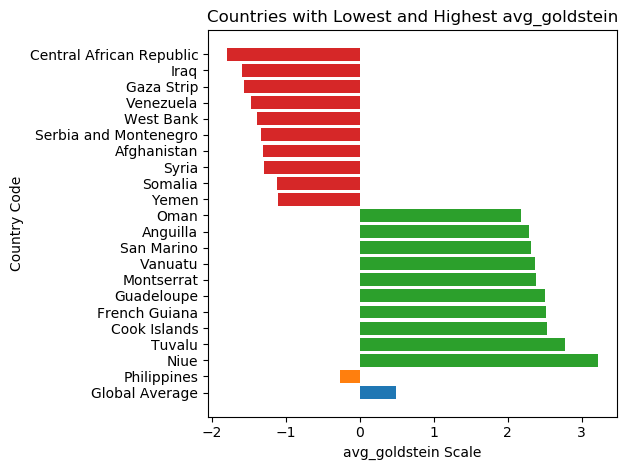

In [89]:
# Plot avg goldstein for the whole 3 month period May June Jul 2017
plot_barchart(df_by_country, 'avg_goldstein')

**The global Average Tone value is -2.05.**

In [161]:
# Get the global mean of avgtone
world = np.sum(df_by_country_month["avgtone * num_mentions"]
               ) / np.sum(df_by_country_month["NumMentions"])
print(f"> loaded global value: {world}")

> loaded global value: -2.052939636155747


The table below show the ten locations (FIPS) with the most negative Average Tone values. The second table shows the value for the Philippines.

In [157]:
# Most Negative Avg Tone
display(df_by_country.sort_values(by='avg_avgtone').head(10)[['avg_avgtone']])

# Philippines avgtone
display(df_by_country[df_by_country.index == 'RP'][['avg_avgtone']])

,avg_avgtone
Actor1Geo_CountryCode,
VE,-5.549178
CT,-5.308697
GZ,-4.808021
CF,-4.754080
CG,-4.663591
YM,-4.552898
YI,-4.538512
BK,-4.483832
IM,-4.473112


,avg_avgtone
Actor1Geo_CountryCode,
RP,-2.97099


The chart below shows the countries with the most positive and most negative Goldstein scores.

**Among the ten countries with the most negative Average Tone, two are from Africa, three are from the Middle East, and three are from Europe. The country with the most negative Average Tone is Venezuela at -5.55. The global average tone is -2.05 while the average tone in the Philippines is -2.97.**

> 230 locations in the dataset
> Sorted according to avg_avgtone and reset index
> loaded Philippines value


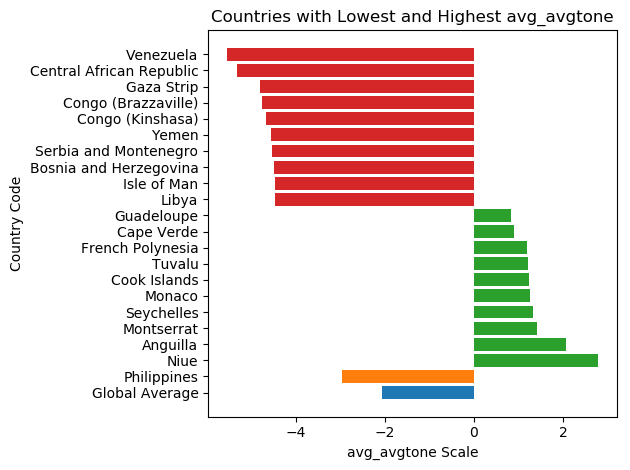

In [162]:
# Plot avg tone for the whole 3 month period May June Jul 2017
plot_barchart(df_by_country, 'avg_avgtone')

### Goldstein and Average Tone per Coordinate

In this section, we plotted a scatterplot of Goldstein and AvgTone values of 1% of all the events from May to July 2017.

We first obtained a sample of 1% of the dataset which would be plotted in a scatterplot.

In [25]:
# Get a sample for plotting
frac = 0.01
df_events_sample = df_.sample(frac=frac).persist()
print(f"> Obtained a {frac} sample for plotting.")
print("> Selected data persisted into workers.")

> Obtained a 0.01 sample for plotting.
> Selected data persisted into workers.


The sampled dataset was saved in a csv for quick reference.

In [26]:
# Save sample to csv
df_events_sample.compute().to_csv("data/df_events_sample_coord.csv")
print("> df_events_sample_coord saved to csv")

> df_events_sample_coord saved to csv


The dataset saved above was then loaded in a dataframe.

In [27]:
# Load df_events_sample.csv
df_events_sample = pd.read_csv("data/df_events_sample_coord.csv")
df_events_sample.head()

,GlobalEventID,Day,MonthYear,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_Lat,Actor1Geo_Long,Actor1Geo_CountryCode,Actor1Geo_Fullname,goldstein * num_mentions,avgtone * num_mentions
0,651554801,20170501.0,201705.0,3.4,2.0,1.0,2.0,3.720930,6.41667,2.88333,NI,"Badagry, Lagos, Nigeria",6.8,7.441860
1,651555864,20170501.0,201705.0,0.0,2.0,1.0,2.0,-1.620746,39.01940,125.75500,KN,"Pyongyang, P'yongyang-si, North Korea",0.0,-3.241491
2,651554398,20170501.0,201705.0,-2.0,4.0,1.0,4.0,-8.097166,NaN,NaN,NaN,NaN,-8.0,-32.388664
3,651555218,20170501.0,201705.0,1.0,2.0,1.0,2.0,-5.263158,35.84690,38.54430,SY,"Tabqa, Ar Raqqah, Syria",2.0,-10.526316
4,651554564,20170501.0,201705.0,-2.0,10.0,1.0,10.0,1.926164,13.00000,105.00000,CB,Cambodia,-20.0,19.261637


The chart below shows the distribution of Avg Tone values in the sampled dataset. The global average value in the sample was found to be -2.01.

> Mean of AvgTone in the sampled dataset: -2.0118533449488623


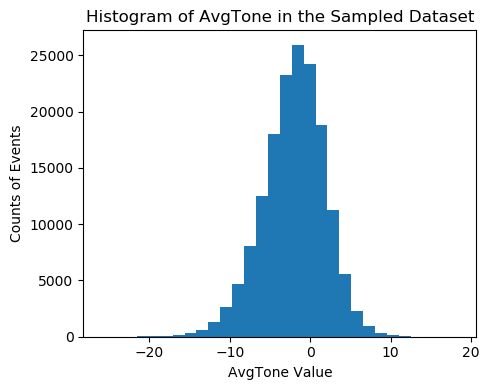

In [217]:
plt.figure(figsize=(5,4))
plt.hist(df_events_sample.AvgTone, bins=30);
plt.title("Histogram of AvgTone in the Sampled Dataset")
plt.ylabel("Counts of Events")
plt.xlabel("AvgTone Value")
plt.tight_layout()
plt.savefig("charts/histogram_avgtone.png", dpi=150)
print(f"> Mean of AvgTone in the sampled dataset: {np.mean(df_events_sample.AvgTone)}")

The chart below shows the distribution of Goldstein values in the sampled dataset. The global average value in the sample was found to be 0.56.

> Mean of Goldstein in the sampled dataset: 0.5601541523789445


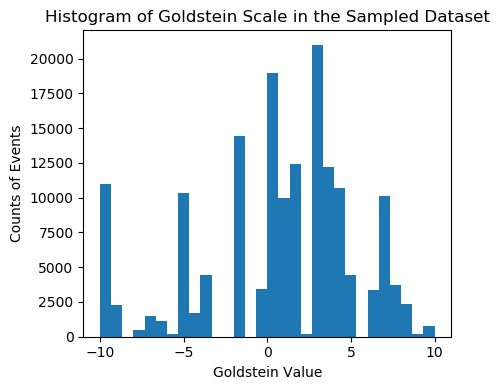

In [218]:
plt.figure(figsize=(5,4))
plt.hist(df_events_sample.GoldsteinScale, bins=30);
plt.title("Histogram of Goldstein Scale in the Sampled Dataset")
plt.ylabel("Counts of Events")
plt.xlabel("Goldstein Value")
plt.tight_layout()
plt.savefig("charts/histogram_goldstein.png", dpi=150)
print(f"> Mean of Goldstein in the sampled dataset: {np.mean(df_events_sample.GoldsteinScale)}")

The longitudes and latitudes of each event and the corresponding Goldstein and Avg Tone values were extracted from the dataset.

In [177]:
# Plot the longitudes and latitudes color coded according to Goldstein value
y = df_events_sample['Actor1Geo_Lat']
x = df_events_sample['Actor1Geo_Long']
goldstein = df_events_sample['GoldsteinScale']
avgtone = df_events_sample['AvgTone']
num_mentions = df_events_sample['NumMentions']
print("> Coordinates and other valuable data to be visualized computed successfully.")

> Coordinates and other valuable data to be visualized computed successfully.


The events were plotted according to coordinates and color coded by Goldstein Score (red being most negative, green being most positive, and yellow as most neutral). The size of each marker represents the number of mentions of the event (importance). **Although negaive values are generally present globally, there are observable prominent red patches in some parts of the US, South America, Middle East, and Africa.**

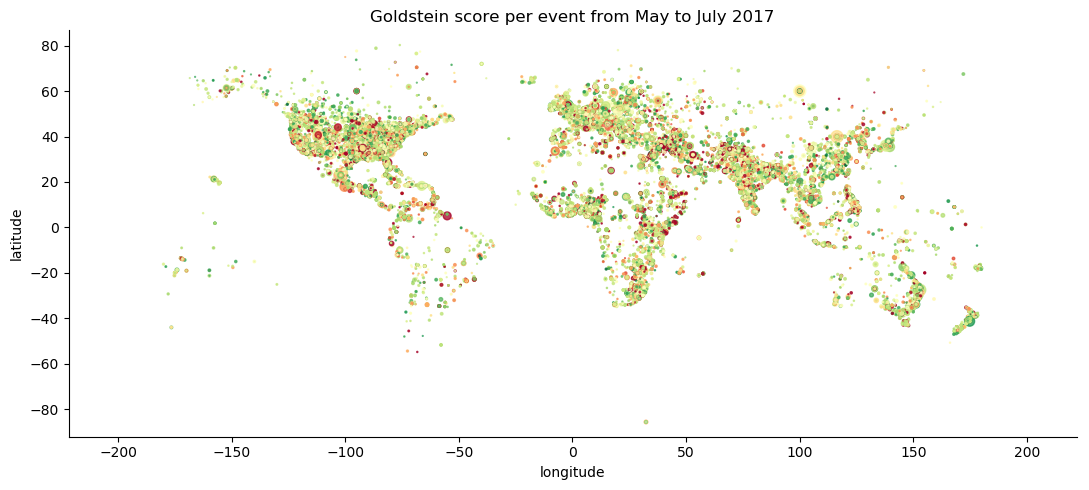

In [292]:
# Goldstein values vs Latitude and Longitude
# Color is goldstein while size is importance (num_mentions)
plt.style.use('default')
f, ax = plt.subplots(figsize=(11,5))
ax.scatter(x, y, c=goldstein, marker='o', s=num_mentions/3, cmap='RdYlGn', alpha=0.75)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.axis('equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Goldstein score per event from May to July 2017')
plt.tight_layout()

# Save figure
plt.savefig("charts/scatter_goldstein_world.png", dpi=150)

To see the locations of top 5% most positive and most negative events, we filtered the events with Goldstein values belonging in the bottom 5th percentile and top 95th percentile.

In [346]:
# Plot the longitudes and latitudes color coded according to Goldstein value
# Filter Goldstein values in the 5th percentile and below


def plot_percentiles(name, df, value, percentile):
    """Given dataframe, value to plot (str) and percentile, we plot the top and bottom percentile"""

    df_red1 = df[df[value] <= df[value].quantile(percentile)]

    y_red1 = df_red1['Actor1Geo_Lat']
    x_red1 = df_red1['Actor1Geo_Long']
    goldstein_red1 = df_red1[value]
    num_mentions_red1 = df_red1['NumMentions']
    print(f"> {value} values in the bottom {percentile} calculated successfully.")

    # Filter Values in the 95th percentile and above

    df_green1 = df[df[value] >= df[value].quantile(1 - percentile)]

    y_green1 = df_green1['Actor1Geo_Lat']
    x_green1 = df_green1['Actor1Geo_Long']
    goldstein_green1 = df_green1[value]
    num_mentions_green1 = df_green1['NumMentions']
    print(
        f"> {value} values in the top {percentile} calculated successfully.")
    print(f"> Coordinates and other valuable data to be visualized computed successfully.")

    # Values vs Latitude and Longitude
    # Color is goldstein while size is importance (num_mentions)

    # BOTTOM 5%

    plt.style.use('default')
    f, ax = plt.subplots(figsize=(11, 5))
    ax.scatter(x_red1, y_red1, c='r', marker='o', s=num_mentions /
               3, alpha=1., label=f'bottom {percentile*100}%')
    ax.scatter(x_green1, y_green1, c='g', marker='o',
               s=num_mentions/3, alpha=0.5, label=f'top {percentile*100}%')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.axis('equal')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title(
        f'5% Most Positive and Negative {value} scores per location from May to July 2017')
    plt.legend()
    plt.tight_layout()

    # Save figure
    plt.savefig(f"charts/scatter_{value}_{name}_top_bottom.png", dpi=150)

The chart below shows the 10% of events with most negative and 10% of events with positive Goldstein values. Notable is the distribution of events in the Middle East. **Some areas in the Middle East have markedly more negative Goldstein values than positive ones.**

> GoldsteinScale values in the bottom 0.1 calculated successfully.
> GoldsteinScale values in the top 0.1 calculated successfully.
> Coordinates and other valuable data to be visualized computed successfully.


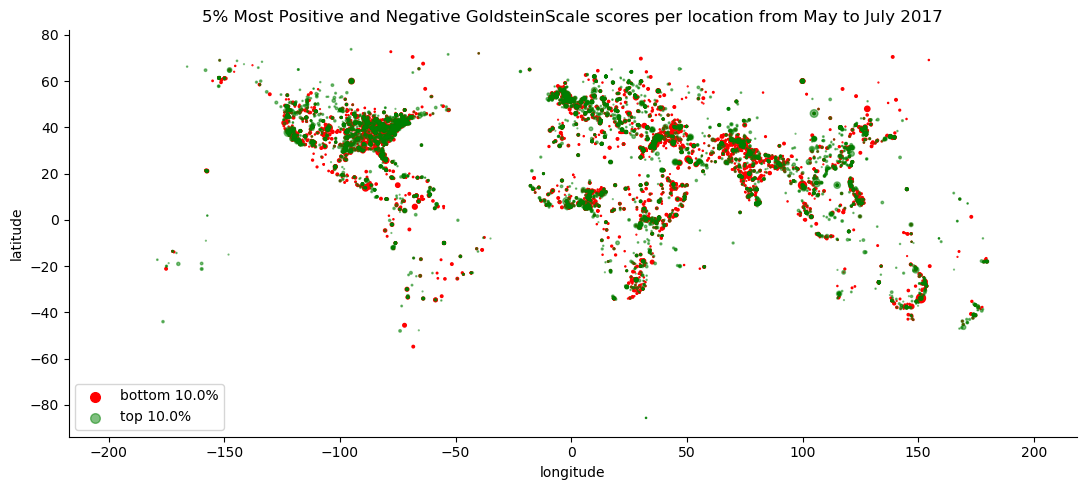

In [347]:
plot_percentiles('world', df_events_sample, 'GoldsteinScale', 0.1)

Similarly, the events were plotted according to coordinates and color coded by Avg Tone (red being most negative, green being most positive, and yellow as neutral). The size of each marker represents the number of mentions of the event (importance).

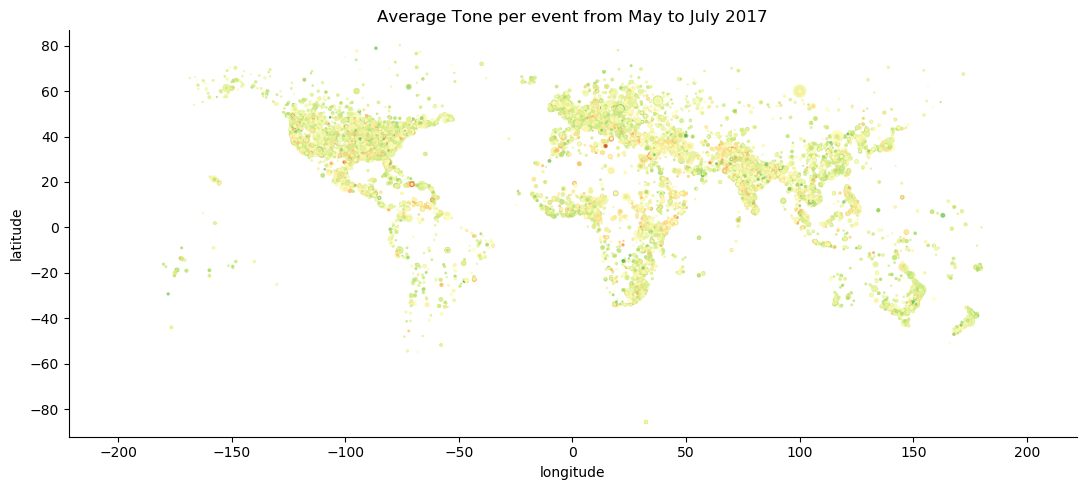

In [315]:
# AvgTone values vs Latitude and Longitude
# Color is avg tone while size is importance (num_mentions)
f, ax = plt.subplots(figsize=(11,5))
ax.scatter(x, y, c=avgtone, marker='o', s=num_mentions/3, cmap='RdYlGn', alpha=0.75)
plt.axis('equal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Average Tone per event from May to July 2017')
plt.tight_layout()

# Save figure
plt.savefig("charts/scatter_avgtone_world.png", dpi=150)

The chart below shows the 10% of events with most negative and 10% of events with positive AvgTone values. Notable is the distribution of events in the Middle East and Africa. **Some areas in the Middle East and Africa have markedly more negative Goldstein values than positive ones.**

> AvgTone values in the bottom 0.1 calculated successfully.
> AvgTone values in the top 0.1 calculated successfully.
> Coordinates and other valuable data to be visualized computed successfully.


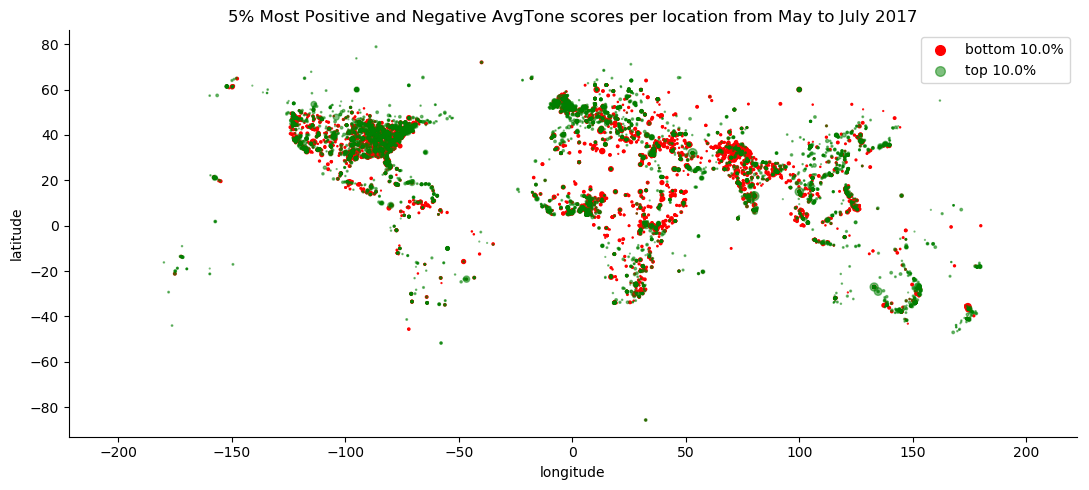

In [331]:
plot_percentiles('world', df_events_sample, 'AvgTone', 0.1)

### Goldstein and Average Tone per Coordinate in the Philippines

To see the events in the Philippines, we first filtered only the data for the Philippines from the whole dataset from May to July 2017.

In [ ]:
# Filter Philippines dataframe
df_ph = df_[df_.Actor1Geo_CountryCode == 'RP']
print("> Selected Philippines and successfully computed")

We saved the sampled dataset to a csv file.

In [133]:
# Save to csv
df_ph.compute().to_csv("data/df_ph_coord.csv")
print("> Successfully saved Ph sample to csv")

> Successfully saved Ph sample to csv


We loaded the csv file into a dataframe.

In [134]:
# Load
df_ph = pd.read_csv("data/df_ph_coord.csv")

Below are the first five rows in the loaded dataset.

In [136]:
df_ph.head()

,GlobalEventID,Day,MonthYear,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_Lat,Actor1Geo_Long,Actor1Geo_CountryCode,Actor1Geo_Fullname,goldstein * num_mentions,avgtone * num_mentions
0,651554620,20170501.0,201705.0,0.0,8.0,1.0,8.0,0.281690,7.07306,125.613,RP,"Davao, Davao City, Philippines",0.0,2.253521
1,651554629,20170501.0,201705.0,-2.0,2.0,1.0,2.0,0.281690,7.07306,125.613,RP,"Davao, Davao City, Philippines",-4.0,0.563380
2,651554633,20170501.0,201705.0,1.0,2.0,1.0,2.0,-3.225806,13.00000,122.000,RP,Philippines,2.0,-6.451613
3,651555083,20170501.0,201705.0,3.5,8.0,1.0,8.0,0.281690,7.07306,125.613,RP,"Davao, Davao City, Philippines",28.0,2.253521
4,651555310,20170501.0,201705.0,4.0,10.0,1.0,10.0,-2.056075,13.00000,122.000,RP,Philippines,40.0,-20.560748


We selected the latitudes and longitudes to be plotted.

In [135]:
# Get Latitude and Longitude
y2 = df_ph['Actor1Geo_Lat']
x2 = df_ph['Actor1Geo_Long']
print("> Coordinates to be visualized computed successfully.")

> Coordinates to be visualized computed successfully.


We selected the Goldstein and AvgTone values to be plotted.

In [317]:
# Get goldstein and avgtone values
goldstein2 = df_ph['GoldsteinScale']
avgtone2 = df_ph['AvgTone']
num_mentions2 = df_ph['NumMentions']
print("> Other valuable data to be visualized computed successfully.")

> Other valuable data to be visualized computed successfully.


Below is the plot of all Goldstein values of events in the Philippines during the three-month period.

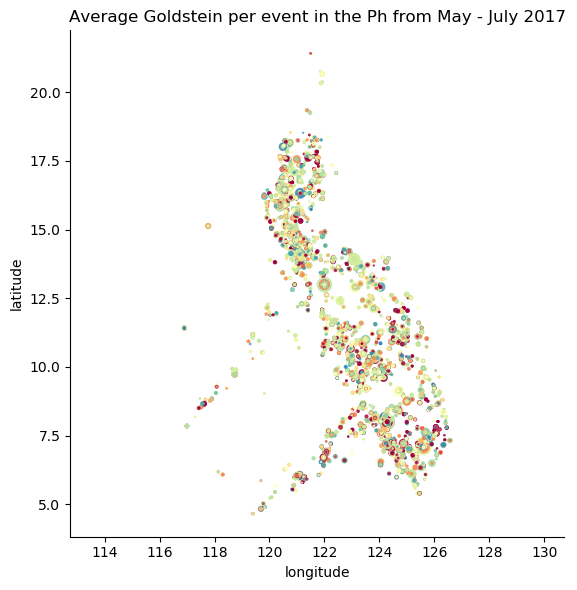

In [349]:
# Goldstein values vs Latitude and Longitude
# Color is goldstein while size is importance (num_mentions)
plt.style.use('default')
f, ax = plt.subplots(figsize=(6,6))
ax.scatter(x2, y2, c=goldstein2, marker='o', s=num_mentions2/2, cmap='Spectral', alpha=0.75)
plt.axis('equal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Average Goldstein per event in the Ph from May - July 2017')
plt.tight_layout()
plt.savefig('charts/scatter_goldstein_ph.png', dpi=150)

Below is the plot of all AvgTone values of events in the Philippines during the three-month period.

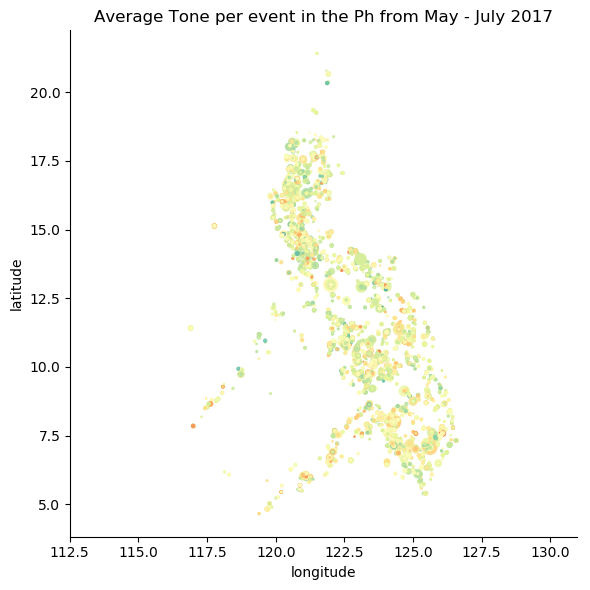

In [350]:
# AvgTone values vs Latitude and Longitude
# Color is goldstein while size is importance (num_mentions)
f, ax = plt.subplots(figsize=(6,6))
ax.scatter(x2, y2, c=avgtone2, marker='o', s=num_mentions2/2, cmap='Spectral', alpha=0.75)
plt.axis('equal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Average Tone per event in the Ph from May - July 2017')
plt.tight_layout()
plt.savefig('charts/scatter_avgtone_ph.png', dpi=150)

From the chart below, we can't visually find a distinct concentration of negative or positive Goldstein values in an area.

> GoldsteinScale values in the bottom 0.1 calculated successfully.
> GoldsteinScale values in the top 0.1 calculated successfully.
> Coordinates and other valuable data to be visualized computed successfully.


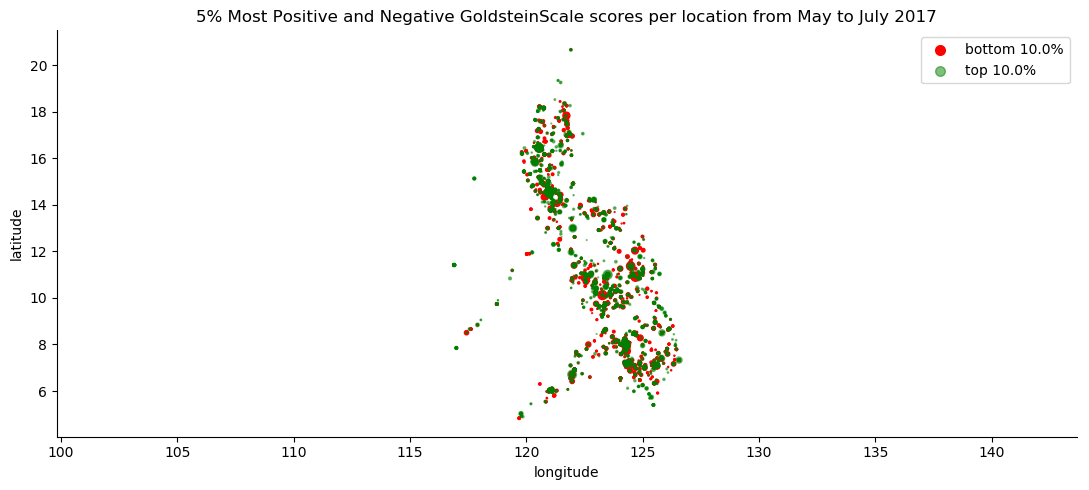

In [342]:
plot_percentiles('ph', df_ph, 'GoldsteinScale', 0.1)

From the chart below, we can see a relatively high concentration of negative AvgTone compared with positive AvgTone in the Visayas and Mindanao regions.

> AvgTone values in the bottom 0.1 calculated successfully.
> AvgTone values in the top 0.1 calculated successfully.
> Coordinates and other valuable data to be visualized computed successfully.


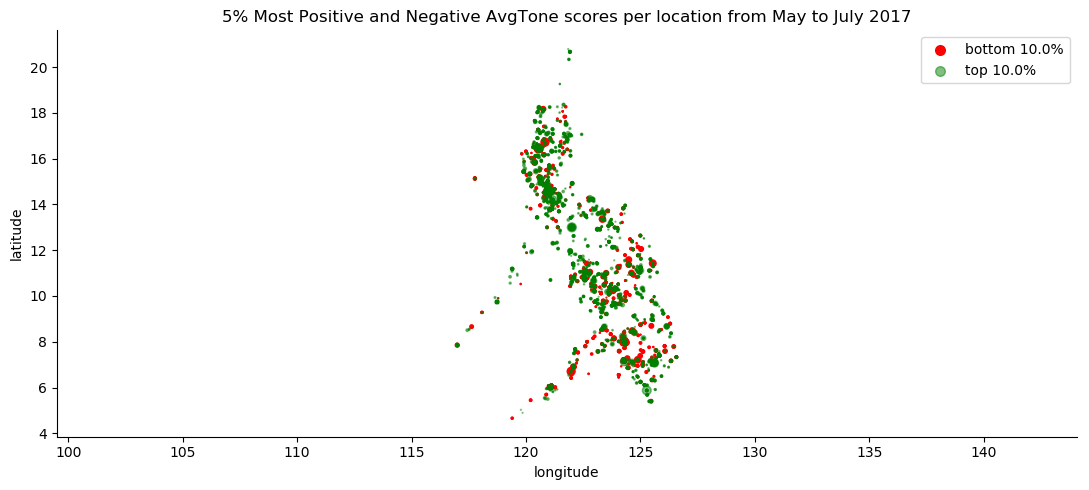

In [341]:
plot_percentiles('ph', df_ph, 'AvgTone', 0.1)

## Methodology

< Complete methodology stated, described and justified>

## Results

< results presented are clean, robust and relevant that will allow a strong
answer or solution to the stated problem>

< explicit answer to the stated problem and presented interesting insights on
that can be traced back to the methods and discussion results >

## References

http://web.pdx.edu/~kinsella/jgscale.html

## Acknowledgements

## Test Code